In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

/tmp/ipykernel_3498837/3527511527.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"SO":"SO",
"MO": "MO",
"MO_equalclustersize": "5 x population size",
"MO_balanced": "Balanced k-leader",
"MO_k2": "Balanced k-2-Leader",
"MO_frac1": "Restricted Donor Population",
"MO_equalclustersize_balanced_frac1": "",
"MO_equalclustersize_k2_frac1": "Balanced k-2-Leader restricted donor population",
"MO_equalclustersize_k2_frac1_noadf":"",
"MO_equalclustersize_balanced_discount":"",
"MO_equalclustersize_balanced_frac1_discount":"",
"MO_equalclustersize_k2_noadf":"",
"MO_equalclustersize_k2":"",
"MO_equalclustersize_balanced":"",
"MO_equalclustersize_frac1":"",
"tree_7":"",
"tree_42":"",
"tree_44":"",
"MO_nocluster": "MO without clustering",
"MO_k2_frac1":"MO_k2_frac1"
}

In [3]:


def statistics_latex(hv_list, dataset, appendix):
    try:
        print("#"*20, dataset, appendix, "#"*20)
        print(sorted(list(hv_list.keys())))

        stri = ""
        for x in ["{0:.3f} $\\pm$ {1:.3f}".format(np.mean(hv_list[k]), np.std(hv_list[k])) for k in sorted(list(hv_list.keys()))]:
            stri += x + " & "
        print(stri)
        
        print([len(hv_list[k][0]) for k in sorted(list(hv_list.keys()))])
        x = sp.posthoc_wilcoxon([hv_list[k][0] for k in sorted(list(hv_list.keys()))], p_adjust="Holm")
        print(x)
        print("#"*20)
        return x
    except Exception as e:
        print("stats", e)
        pass

def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))


def make_plots(d, folder, x_index, appendix):
    
    for el in experiments:
        fig = plt.figure()
        plt.title("Dataset: {}".format(dataset.capitalize()))
        markers = ['o', 'x', '^','s']
        x = []

        hv_list = defaultdict(list)

        for key in d.keys():
            if key in el:
                x = d[key][x_index]
                y = d[key][1]

                gens = np.mean(d[key][2])
                
                print(x_index, max_size, max_complexity)
                #hvs = calc_hv(dataset_filename_fronts, dataset, key, x_index, max_size)
                hvs = calc_hv_3d(dataset_filename_fronts, dataset, key, x_index, max_size, max_complexity)
                
                print(hvs)

                hv_list[key].append(hvs)

                coefficients = np.polyfit(x, y, deg=5)  # Adjust the degree of polynomial as needed
                poly = np.poly1d(coefficients)

                # Generate points for the fitted curve
                x_fit = np.linspace(min(x), max(x), 1000)
                y_fit = poly(x_fit)


                # Plot scatter plot and line plot
                color = sns.color_palette()[int(el.index(key))]  # Get color from tab10 colormap
                marker = markers[int(el.index(key))]
                
                print("MEAN ", key, np.mean(hvs))

                plt.scatter(x, y, alpha=0.4, s=18, label=translation_dict[key] + " Average HV={0:.3f}, \n Average generations={1:.1f}".format(np.mean(hvs), gens), color=color, marker=marker)
                #plt.plot(x_fit, y_fit, c=color, alpha=0.5)

                # Commented out, because extreme slow
                # print("nondom")
                # nondom_list_x, nondom_list_y = non_dom(x,y)
                # plt.plot(nondom_list_x, nondom_list_y, linestyle='--', c=color,alpha=0.5)
                # print("done")

        statistics(hv_list, dataset, appendix)      

        if(len(x)>0):
            plt.xlim(0.5,None)
            plt.xlabel(r'$R^2$')
            plt.ylabel('Expression size')
            # plt.yscale('log', base=5)
            plt.legend()
            fig.set_size_inches(10, 10)

            #plt.gca().set_aspect('equal')

            directory = "./results/plots/" + folder
            isExist = os.path.exists(directory)
            if not isExist:
                os.makedirs(directory)

            if max_gen is None:
                plt.savefig(directory + "/{}_{}.png".format(dataset + "".join(el), appendix), dpi=600, bbox_inches='tight')
            else:
                plt.savefig(directory + "/{}_{}gen_{}.png".format(dataset + "".join(el), max_gen, appendix), dpi=600, bbox_inches='tight')
            plt.show()
        plt.close()

def get_mses(d, folder, x_index, appendix):
    pass





In [4]:
experiments = [
    ['SO','MO'],
    #['SO','MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize', 'MO_balanced', 'MO_k2', 'MO_frac1'], 
    #['MO_equalclustersize_frac1', 'MO_equalclustersize_balanced', 'MO_equalclustersize_k2'], 
    #['MO_equalclustersize_balanced_frac1','MO_equalclustersize_k2_frac1','SO'],
    #['MO_equalclustersize_k2_frac1_noadf, MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize_balanced_discount','MO_equalclustersize_k2_frac1','SO','MO_equalclustersize_balanced_frac1_discount'],
    #['MO_equalclustersize_k2_noadf','MO_equalclustersize_k2'],
    #['tree_7','tree_42','tree_44'],
    #["MO","MO_nocluster"]
    ]


big_list = []
for sublist in experiments:
    big_list.extend(sublist)






#
for dataset in ["air", "bike", "concrete","dowchemical","tower", "synthetic_dataset"]:
#for dataset in ["Concrete"]:

    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = "multi"
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

        if d_key not in big_list:
            continue

        if(dataset in filename):
            try:

                scatter_x = []
                scatter_y = []
                scatter_z = []

                scatter_x_val = []
                 
                #, error_bad_lines=False
                df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
                

                gens = len(df.iloc[-1][9].split(","))


                mg = -1
                if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                    mg = max_gen - 1

                for el in df.iloc[-1][14].split(";")[mg].split("],"):
                    rep = el.replace("[","").replace("{","").split(",")
                    
                    if max_expr_size is not None:
                        if float(rep[2])>max_expr_size:
                            continue
                    scatter_x.append(1. - float(rep[0])/float(df.iloc[-1][7]))
                    scatter_y.append(float(rep[2]))
                    scatter_z.append(float(rep[4]))

                    scatter_x_val.append(1. - float(rep[1])/float(df.iloc[-1][8]))

                    if float(rep[2])>max_size:
                        max_size = float(rep[2])

                    if float(rep[4])>max_complexity and not np.isinf(float(rep[4])):
                        max_complexity = float(rep[4])

                dataset_filename_fronts[dataset][d_key].append((scatter_x,scatter_y,gens,scatter_x_val,scatter_z))

                d[d_key][0].extend(scatter_x)
                d[d_key][1].extend(scatter_y)
                d[d_key][2].append(gens)
                d[d_key][3].extend(scatter_x_val)
                d[d_key][4].append(df.iloc[-1][1])
                d[d_key][5].extend(scatter_z)
                c[d_key] += df.iloc[-1][1]<0.001
                
                try:
                    
                    mse_list = [str("{:.6f}".format(float(val))) for val in df.iloc[-1][16].split(",")]
                    
                    time[d_key] += float(mse_list[[str(best_mse).rstrip("0") for best_mse in df.iloc[-1][9].split(",")].index(str("{:.6f}".format(float(df.iloc[-1][1]))).rstrip("0"))])
                    #print(d_key, df.iloc[-1][1],df.iloc[-1][15].split(",")[-1], len(df.iloc[-1][15].split(",")), float(df.iloc[-1][15].split(",")[-1])-float(df.iloc[-1][15].split(",")[-2]))
                except Exception as e:
                    print(traceback.format_exc())
                    print(e)
                    quit()
                    pass
            except Exception as e:
                print(traceback.format_exc())
                quit()
                pass
    print("Times FOUND")
    for k in c.keys():
        print(k, c[k], time[k]/30.)
    # print("DATASET", dataset) 
    # for d_key in sorted(list(d.keys()), key=lambda d_key: np.mean(d[d_key][4])):
    #     print(d_key)
    #     print(np.mean(d[d_key][4]), len(d[d_key][4]))


    print("-"*10,"Train","-"*10)
    make_plots(d, folder, x_index=0, appendix="train")
    # print("-"*10,"Validation","-"*10)
    # make_plots(d, folder, x_index=3, appendix="val")

Times FOUND
---------- Train ----------
#################### air train ####################
Times FOUND
---------- Train ----------
#################### bike train ####################
Times FOUND
---------- Train ----------
#################### concrete train ####################
Times FOUND
---------- Train ----------
#################### dowchemical train ####################
Times FOUND
---------- Train ----------
#################### tower train ####################
Times FOUND
---------- Train ----------
#################### synthetic_dataset train ####################


In [66]:
def get_significantly_better_index(meds):
    df = ((sp.posthoc_wilcoxon(meds, p_adjust="Holm", zero_method="zsplit") < 0.05).astype(int).sum()==(len(meds)-1)).astype(int)
    new_df = df

    for index, row in df.items():

        if row>0:
            
            if (np.median(meds[index-1])>[np.median(meds[(index + i) % (len(meds))]) for i in range(len(meds)-1)]).all():
                new_df.iloc[index-1] = 1
            else:
                new_df.iloc[index-1] = 0

    best_index = np.argwhere(new_df.to_numpy()>0)
    
    if len(best_index)>0:
        
        return best_index[0][0]
    return None

def get_hv(x,y,z, mse_mode=False, third_objective=False):
    #x_array = 1.-np.maximum(np.array(x),0.)
    if mse_mode:
        x_array = (np.array(x)-min_mse)/(max_mse-min_mse)
    else:
        x_array = (np.array(x)-min_x)/(max_x-min_x)
        x_array = 1.-np.maximum(x_array,0.)
    
    y_array = (np.array(y)-min_y)/(max_y-min_y)
    z_array = (np.array(z)-min_z)/(max_z-min_z)


    
    result = np.column_stack((x_array, y_array))

    ref_point = np.array([1., 1.])
    
    if third_objective:
        result = np.column_stack((x_array, y_array, z_array))

        ref_point = np.array([1., 1., 1.])

    ind = HV(ref_point=ref_point)

    return ind(result)

def get_hvs(x,y,z,mse_mode=False, third_objective=False):
    hvs = []
    for x_val, y_val, z_val in zip(x,y,z):
        hvs.append(get_hv([x_val], [y_val], [z_val], mse_mode, third_objective))
    return hvs

In [70]:
min_x = 999999999.
max_x = 0.
min_y = 999999999.
max_y = 0.
min_z = 999999999.
max_z = 0.
max_mse = 0.
min_mse = 999999999999.

# TODO: REMOVE!!!!!!!
max_gen = None

experiments = ["MO", "MO_512", "MO_2048", "SO_512", "SO_2048", "MO_nocluster", "SO", "MO_equalclustersize", "MO_equalclustersize_k2_2objs", "MO_balanced", "MO_k2", "MO_frac1", "MO_equalclustersize_k2", "MO_equalclustersize_balanced", "MO_equalclustersize_k2_discounted","MO_equalclustersize_k2_frac1", "MO_equalclustersize_k2_sample", "SO_sample"]
datasets = ["air","bike","concrete","dowchemical","tower"]

dataset_filename = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for dataset in datasets:
    folder = "2hr"
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        nr = int(filename.split("/")[-1].split("_")[0])
        
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]
        
 
        if d_key not in experiments:
            continue

#         if nr!=1:
#             continue

        if(dataset in filename):

            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            scatter_x = []
            scatter_mse = []
            scatter_y = []
            scatter_z = []
            
            mg = -1
            if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                mg = max_gen - 1

            for el in df.iloc[-1][14].split(";")[mg].split("],"):
                rep = el.replace("[","").replace("{","").split(",")

                scatter_x.append(1. - (float(rep[0])/float(df.iloc[-1][7])))
                scatter_y.append(float(rep[2]))
                scatter_z.append(float(rep[4]))
                scatter_mse.append(float(rep[0]))


                if float(rep[2])>max_y:
                    max_y = float(rep[2])
                if float(rep[2])<min_y:
                    min_y = float(rep[2])
                 
                if float(rep[0])>max_mse:
                    max_mse = float(rep[0])
                if float(rep[0])<min_mse:
                    min_mse = float(rep[0])
                    
                 
                if (1.-float(rep[0])/float(df.iloc[-1][7]))>max_x:
                    max_x = (1.-float(rep[0])/float(df.iloc[-1][7]))
                if (1.-float(rep[0])/float(df.iloc[-1][7]))<min_x:
                    min_x = (1.-float(rep[0])/float(df.iloc[-1][7]))
                
                
                if float(rep[4])>max_z and not np.isinf(float(rep[4])):
                    max_z = float(rep[4])
                if float(rep[4])<min_z and not np.isinf(float(rep[4])):
                    min_z = float(rep[4])
            
            dataset_filename[dataset][d_key]["x"].extend(scatter_x)
            dataset_filename[dataset][d_key]["mse"].extend(scatter_mse)
            dataset_filename[dataset][d_key]["y"].extend(scatter_y)
            dataset_filename[dataset][d_key]["z"].extend(scatter_z)
            dataset_filename[dataset][d_key]["gens"].append(len(df.iloc[-1][16].split(",")))
    
    for k in dataset_filename[dataset].keys():
        dataset_filename[dataset][k]["hvs"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"])
        dataset_filename[dataset][k]["avg_hv"] = np.mean(dataset_filename[dataset][k]["hvs"])
        
        dataset_filename[dataset][k]["hvs_mse"] = get_hvs(dataset_filename[dataset][k]["mse"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"],True)
        dataset_filename[dataset][k]["avg_hv_mse"] = np.mean(dataset_filename[dataset][k]["hvs_mse"])
        
        dataset_filename[dataset][k]["hvs_3d"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], third_objective=True)
        dataset_filename[dataset][k]["avg_hv_3d"] = np.mean(dataset_filename[dataset][k]["hvs_3d"])
        
        dataset_filename[dataset][k]["total_hv"] = get_hv(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"])
        
    
algorithms = ["MO", "MO_512", "MO_2048", "SO_512", "SO_2048", "MO_nocluster", "SO", "MO_equalclustersize", "MO_balanced", "MO_k2", "MO_frac1", "MO_equalclustersize_k2", "MO_equalclustersize_k2_discounted","MO_equalclustersize_k2_frac1", "MO_equalclustersize_k2_sample", "SO_sample"]
for dataset in datasets:
    print(dataset)
    meds = []

    for algorithm in algorithms:
        print(algorithm, dataset_filename[dataset][algorithm]["avg_hv"], dataset_filename[dataset][algorithm]["avg_hv_mse"], dataset_filename[dataset][algorithm]["total_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass
     
        

air
MO 0.5306683353877354 0.5446198780079026 0.8086056445297902 172.4
MO_512 0.5470687525671684 0.5476266351035483 0.7310341708905359 145.5
MO_2048 0.5399919841517918 0.5621260231956348 0.8065239510263815 201.2
SO_512 0.6302317607715282 0.641553218630211 0.9202323216524766 411.0
SO_2048 [] [] [] nan
MO_nocluster 0.5176138096162434 0.5234040760970337 0.6812766977647818 165.0
SO 0.6528156288176746 0.6532296922906601 0.9420140101223509 1217.0
MO_equalclustersize 0.5745818794246205 0.5958219081752463 0.8274256571930021 219.33333333333334
MO_balanced 0.5757943336267104 0.5910888866596503 0.8233925659069531 167.0
MO_k2 0.5645160269274827 0.5765754507124858 0.8081267856148853 158.5
MO_frac1 0.506400421910598 0.5255940870211716 0.8096956873260224 211.75
MO_equalclustersize_k2 0.6320096952451622 0.6419001720741195 0.917162288457422 409.0
MO_equalclustersize_k2_discounted [] [] [] nan
MO_equalclustersize_k2_frac1 0.6226655138059461 0.642999291327668 0.8919644462764051 396.5
MO_equalclustersize_k

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


dowchemical
MO 0.6200735884113905 0.9490718332721055 0.8302285885780508 219.33333333333334
MO_512 0.5675523777795826 0.948838001570857 0.7880136556200406 223.33333333333334
MO_2048 0.644365764006732 0.9422089094200564 0.8151221119175105 244.75
SO_512 0.6453155288166892 0.8690782220210294 0.9076603323733418 558.25
SO_2048 0.6677950285932838 0.8332318874261794 0.9208128757374436 376.3333333333333
MO_nocluster 0.5717948317078038 0.9636122653615016 0.7285743316528838 306.3333333333333
SO 0.661098345307767 0.8805256796998838 0.9102487596069337 428.0
MO_equalclustersize 0.6755863804967241 0.9211118052594418 0.8965755679282694 242.66666666666666
MO_balanced 0.6515425171166321 0.9035890641627854 0.8888675455405395 475.875
MO_k2 0.6059077475257981 0.9301693125381352 0.8526945728134889 293.5
MO_frac1 0.6413992002833124 0.8892498824122324 0.8618747065159782 605.0
MO_equalclustersize_k2 0.6647107180193593 0.844071204862123 0.8990075665475848 418.5
MO_equalclustersize_k2_discounted 0.67997965207901

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Why clustering is needed

In [59]:
algorithms = ["MO", "MO_nocluster"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)
    
    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]

    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO                   0.5306683353877354 172.4
MO_nocluster         0.5176138096162434 165.0
BIKE
----------------------------------------------------------
MO                   0.7411508812168996 388.0
MO_nocluster         0.7267096164024677 283.75


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


CONCRETE
----------------------------------------------------------
MO                   0.62501817785049 177.16666666666666
MO_nocluster         0.5854034023822308 189.6
DOWCHEMICAL
----------------------------------------------------------
MO                   0.6200735884113905 219.33333333333334
MO_nocluster         0.5717948317078038 306.3333333333333
TOWER
----------------------------------------------------------
MO                   0.7429517364809444 403.25
MO_nocluster         0.7371126905897565 1855.6666666666667


# The problem

In [60]:
algorithms = ["MO", "SO"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO                   0.5306683353877354 172.4
SO                   0.6528156288176746 1217.0
SO
BIKE
----------------------------------------------------------
MO                   0.7411508812168996 388.0
SO                   0.7600428038331016 842.0
CONCRETE
----------------------------------------------------------
MO                   0.62501817785049 177.16666666666666
SO                   0.6748287809589275 783.6666666666666
DOWCHEMICAL
----------------------------------------------------------
MO                   0.6200735884113905 219.33333333333334
SO                   0.661098345307767 428.0
SO
TOWER
----------------------------------------------------------
MO                   0.7429517364809444 403.25
SO                   0.7148179556428027 774.5


# The fix

In [72]:
algorithms = ["MO_equalclustersize_k2", "MO_equalclustersize_balanced", "MO_equalclustersize_k2_frac1", "MO_equalclustersize_balanced_frac1", "SO"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO_equalclustersize_k2 0.6320096952451622 409.0
MO_equalclustersize_balanced 0.5970430887513357 254.0
MO_equalclustersize_k2_frac1 0.6226655138059461 396.5
MO_equalclustersize_balanced_frac1 [] nan
SO                   0.6528156288176746 1217.0
BIKE
----------------------------------------------------------
MO_equalclustersize_k2 0.7638054196425822 394.0
MO_equalclustersize_balanced 0.7717771874091379 364.6
MO_equalclustersize_k2_frac1 0.7360991978784243 405.0
MO_equalclustersize_balanced_frac1 [] nan
SO                   0.7600428038331016 842.0
CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2 0.6861393746360268 399.0
MO_equalclustersize_balanced 0.6799371353174085 351.1666666666667
MO_equalclustersize_k2_frac1 0.7172677286638471 356.0
MO_equalclustersize_balanced_frac1 [] nan
SO                   0.6748287809589275 783.6666666666666
DOWCHEMICAL
------------------------------------

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/nu

# Ablations

In [73]:
algorithms = ["MO_equalclustersize", "MO_balanced", "MO_k2", "MO_frac1", "SO"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO_equalclustersize  0.5745818794246205 219.33333333333334
MO_balanced          0.5757943336267104 167.0
MO_k2                0.5645160269274827 158.5
MO_frac1             0.506400421910598 211.75
SO                   0.6528156288176746 1217.0
SO
BIKE
----------------------------------------------------------
MO_equalclustersize  0.7741296204589492 423.5
MO_balanced          0.7617969775975385 435.6
MO_k2                0.7021397105552599 278.0
MO_frac1             0.7310859677342252 176.875
SO                   0.7600428038331016 842.0
CONCRETE
----------------------------------------------------------
MO_equalclustersize  0.6751497865790247 259.8
MO_balanced          0.675938227031813 266.0
MO_k2                0.6064099958793444 178.0
MO_frac1             0.6267114680818031 262.4
SO                   0.6748287809589275 783.6666666666666


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize  0.6755863804967241 242.66666666666666
MO_balanced          0.6515425171166321 475.875
MO_k2                0.6059077475257981 293.5
MO_frac1             0.6413992002833124 605.0
SO                   0.661098345307767 428.0
TOWER
----------------------------------------------------------
MO_equalclustersize  [] nan
MO_balanced          0.769806181212323 493.0
MO_k2                0.7299875913406874 162.33333333333334
MO_frac1             0.7746174368292825 872.5
SO                   0.7148179556428027 774.5


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Another issue: duplicate solutions

In [63]:
algorithms = ["MO_equalclustersize_k2_sample", "MO_equalclustersize_k2", "SO_sample"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
    # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except Exception as e:
        print(e)
        pass

AIR
----------------------------------------------------------
MO_equalclustersize_k2_sample 0.6736915654496043 206.5
MO_equalclustersize_k2 0.6320096952451622 409.0
SO_sample            0.689919647763849 458.5
list indices must be integers or slices, not NoneType
BIKE
----------------------------------------------------------
MO_equalclustersize_k2_sample 0.7760868174563169 289.6666666666667
MO_equalclustersize_k2 0.7638054196425822 394.0
SO_sample            0.7684887642524023 718.6666666666666
list indices must be integers or slices, not NoneType
CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_sample 0.7099726563798862 254.0
MO_equalclustersize_k2 0.6861393746360268 399.0
SO_sample            0.7094800196187964 539.0
list indices must be integers or slices, not NoneType
DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_sample 0.681819160193518 365.0
MO_equalclustersize_k2 0.6647107180193593 418.5


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


# Discounting re-use

In [64]:
algorithms = ["MO_equalclustersize_k2_discounted", "MO_equalclustersize_k2"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
    # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except Exception as e:
        print(e)
        pass

AIR
----------------------------------------------------------
MO_equalclustersize_k2_discounted [] nan
MO_equalclustersize_k2 0.6320096952451622 409.0
float division by zero
BIKE
----------------------------------------------------------
MO_equalclustersize_k2_discounted 0.764321139384333 367.57142857142856
MO_equalclustersize_k2 0.7638054196425822 394.0
list indices must be integers or slices, not NoneType
CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_discounted 0.6646702102101292 382.0
MO_equalclustersize_k2 0.6861393746360268 399.0


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MO_equalclustersize_k2
DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_discounted 0.6799796520790152 337.0
MO_equalclustersize_k2 0.6647107180193593 418.5
MO_equalclustersize_k2_discounted
TOWER
----------------------------------------------------------
MO_equalclustersize_k2_discounted 0.7553644495569867 380.75
MO_equalclustersize_k2 0.7486715551671429 316.3333333333333
list indices must be integers or slices, not NoneType


# Third objective

In [71]:
algorithms = ["MO_equalclustersize_k2_2objs", "SO", "MO_equalclustersize_k2"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
    # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except Exception as e:
        print(e)
        pass
    
algorithms = ["MO_equalclustersize_k2_2objs", "SO", "MO_equalclustersize_k2"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv_3d"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs_3d"])
    # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except Exception as e:
        print(e)
        pass

AIR
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.6081726540914631 347.3333333333333
SO                   0.6528156288176746 1217.0
MO_equalclustersize_k2 0.6320096952451622 409.0
list indices must be integers or slices, not NoneType
BIKE
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.7612156793447736 415.3333333333333
SO                   0.7600428038331016 842.0
MO_equalclustersize_k2 0.7638054196425822 394.0


/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


list indices must be integers or slices, not NoneType
CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.6901861447072238 370.5
SO                   0.6748287809589275 783.6666666666666
MO_equalclustersize_k2 0.6861393746360268 399.0
list indices must be integers or slices, not NoneType
DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.6392588155104241 407.75
SO                   0.661098345307767 428.0
MO_equalclustersize_k2 0.6647107180193593 418.5
list indices must be integers or slices, not NoneType
TOWER
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.7462793750742953 379.5
SO                   0.7148179556428027 774.5
MO_equalclustersize_k2 0.7486715551671429 316.3333333333333
list indices must be integers or slices, not NoneType
AIR
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.3115417470976078 3

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


list indices must be integers or slices, not NoneType
DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.5272547468846533 407.75
SO                   0.5653918962992052 428.0
MO_equalclustersize_k2 0.541695354557616 418.5
SO
TOWER
----------------------------------------------------------
MO_equalclustersize_k2_2objs 0.6394983944312691 379.5
SO                   0.6239344711252446 774.5
MO_equalclustersize_k2 0.6491873494467263 316.3333333333333
list indices must be integers or slices, not NoneType


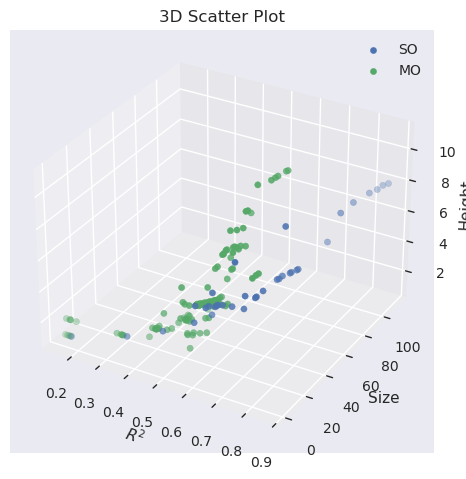

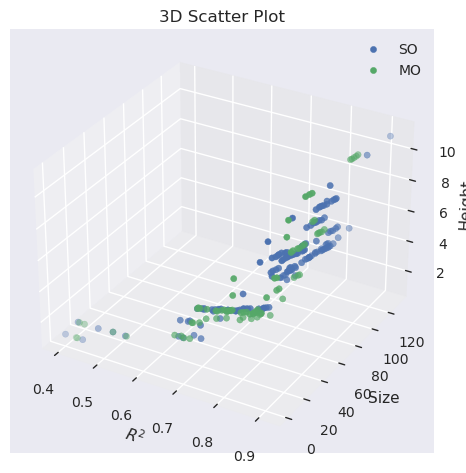

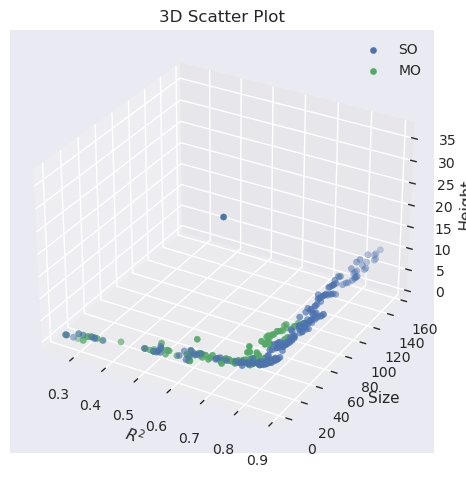

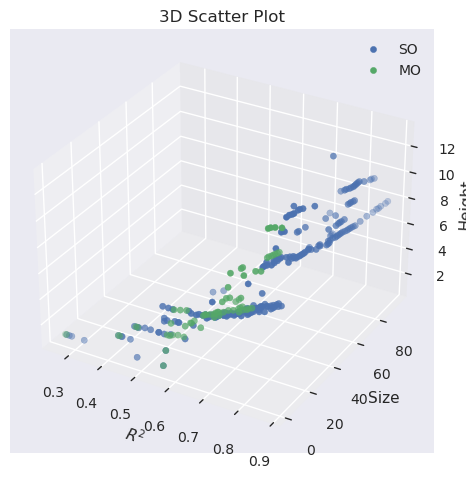

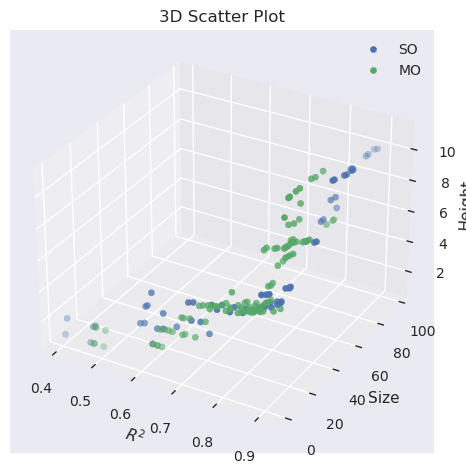

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["SO","MO"]]
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for algorithm in experiment:

            # Sample data
            x = dataset_filename[dataset][algorithm]["x"]
            y = dataset_filename[dataset][algorithm]["y"]
            z = dataset_filename[dataset][algorithm]["z"]



            # Create a 3D scatter plot
            ax.scatter(x, y, z, marker='o', label=algorithm)

        # Customize the plot (optional)
        ax.set_xlabel(r'$R^2$')
        ax.set_ylabel('Size')
        ax.set_zlabel('Height')
        ax.set_title('3D Scatter Plot')
        plt.legend()

        # Show the plot
        plt.show()

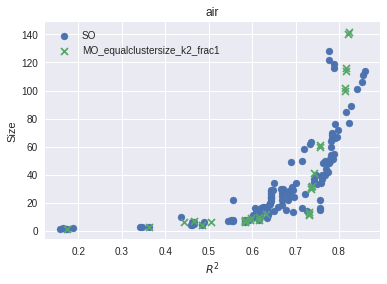

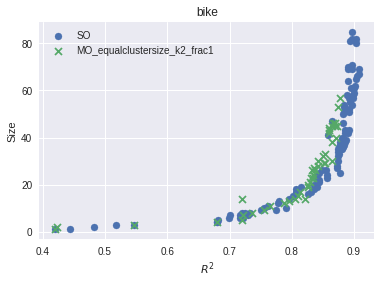

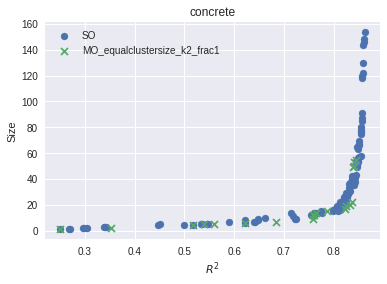

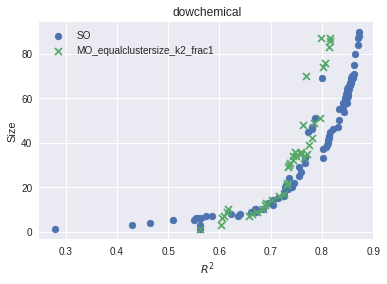

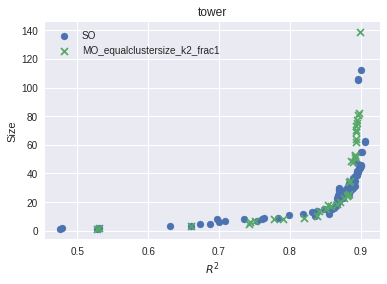

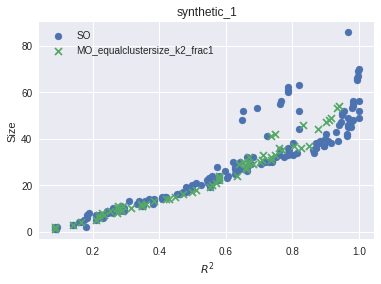

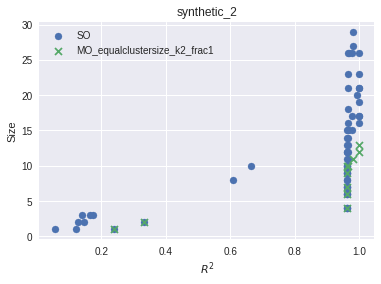

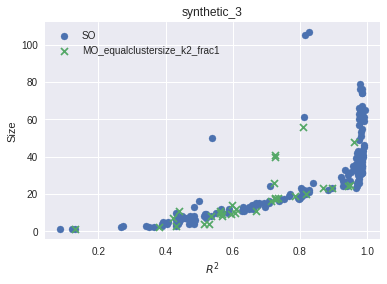

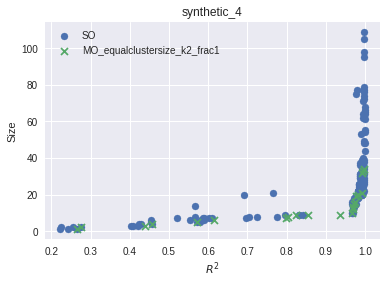

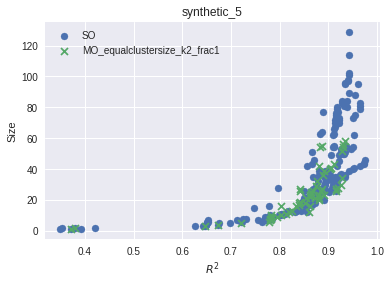

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["SO","MO_equalclustersize_k2_frac1"]]
markers = ['o', 'x', '^','s']
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        plt.figure()

        for algorithm in experiment:

            # Sample data
            x = dataset_filename[dataset][algorithm]["x"]
            y = dataset_filename[dataset][algorithm]["y"]

            # Create a 3D scatter plot
            plt.scatter(x, y, label=algorithm, marker=markers[experiment.index(algorithm)])

        # Customize the plot (optional)
        plt.xlabel(r'$R^2$')
        plt.ylabel('Size')
        plt.title(dataset)
        plt.legend()

        # Show the plot
        plt.show()
        

In [74]:
algorithms = ["MO_equalclustersize_k2", "MO_equalclustersize_balanced", "MO_equalclustersize"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass

AIR
----------------------------------------------------------
MO_equalclustersize_k2 0.6320096952451622 409.0
MO_equalclustersize_balanced 0.5970430887513357 254.0
MO_equalclustersize  0.5745818794246205 219.33333333333334
BIKE
----------------------------------------------------------
MO_equalclustersize_k2 0.7638054196425822 394.0
MO_equalclustersize_balanced 0.7717771874091379 364.6
MO_equalclustersize  0.7741296204589492 423.5
CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2 0.6861393746360268 399.0
MO_equalclustersize_balanced 0.6799371353174085 351.1666666666667
MO_equalclustersize  0.6751497865790247 259.8
DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2 0.6647107180193593 418.5
MO_equalclustersize_balanced 0.6686140317668658 354.0
MO_equalclustersize  0.6755863804967241 242.66666666666666
TOWER
----------------------------------------------------------
MO_equalclustersize_k2 0.74867155516714

/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/scratch1/home/joe/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
